In [1]:
# !pip3 install tensorboardX
# !pip3 install torchvision

In [2]:
# from google.colab import files

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm

from tensorboardX import SummaryWriter
import torchvision.utils as vutils

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# %load_ext tensorboard.notebook

In [4]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
def RandomFunction(x):
    n = 5
    N = np.arange(1, n, 1)
    A = np.random.randn(n)
    B = np.random.randn(n)
    A0 = np.random.randn(1)
    
    y = 0.5*np.ones_like(x)*A0
    
    for n, a, b in zip(N, A, B):
        y += a*np.sin(n*x) + b*np.cos(n*x)
    
    return y

def GenerateImpulses(n = 20, T = 2, phi = 0, k = 2, function = np.sin):
    
    t = int(T)//2
    
    x = np.linspace(start = 0, stop = T*np.pi, num = n)
    
    List_y = []
    
    for i in range(k):
        List_y.append(np.random.randn(1)*function(x + phi))
    
    y = np.array(List_y[0])
    
    for i in range(1, t):
        y2 = List_y[np.random.randint(0, k)]
        
        ind = np.where(x <= 2*(i + 1)*np.pi)
        ind = np.where(x[ind] > 2*i*np.pi)
        y[ind] = y2[ind]
        
    return y
    

def GeneratorOfTimeSeries(n = 100, m = 16384):
    T1 = []
    T2 = []
    T3 = []
    for _ in range(m):
        numPi = 4 + np.random.randint(0, 20)
        phi = np.random.rand(1)*2*np.pi
        function = np.sin
        if np.random.rand() < -4*0.5:
            function = RandomFunction
            
        series = GenerateImpulses(n = n, T = numPi, phi = phi, k = np.random.randint(1, 2), function=function)
        T1.append(series)
    T1 = np.asarray(T1)
    
    return np.reshape(T1, [T1.shape[0], T1.shape[1], 1])

  
class TimeSeries(Dataset):
    def __init__(self, X, Y, device = 'cpu'):
        super(TimeSeries, self).__init__()
        self.X = torch.FloatTensor(X).to(device)
        self.Y = torch.FloatTensor(Y).to(device)
        self.len = X.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [7]:
X_train = GeneratorOfTimeSeries(n = 400, m = 128)

In [8]:
X_test = GeneratorOfTimeSeries(n = 400, m = 8)

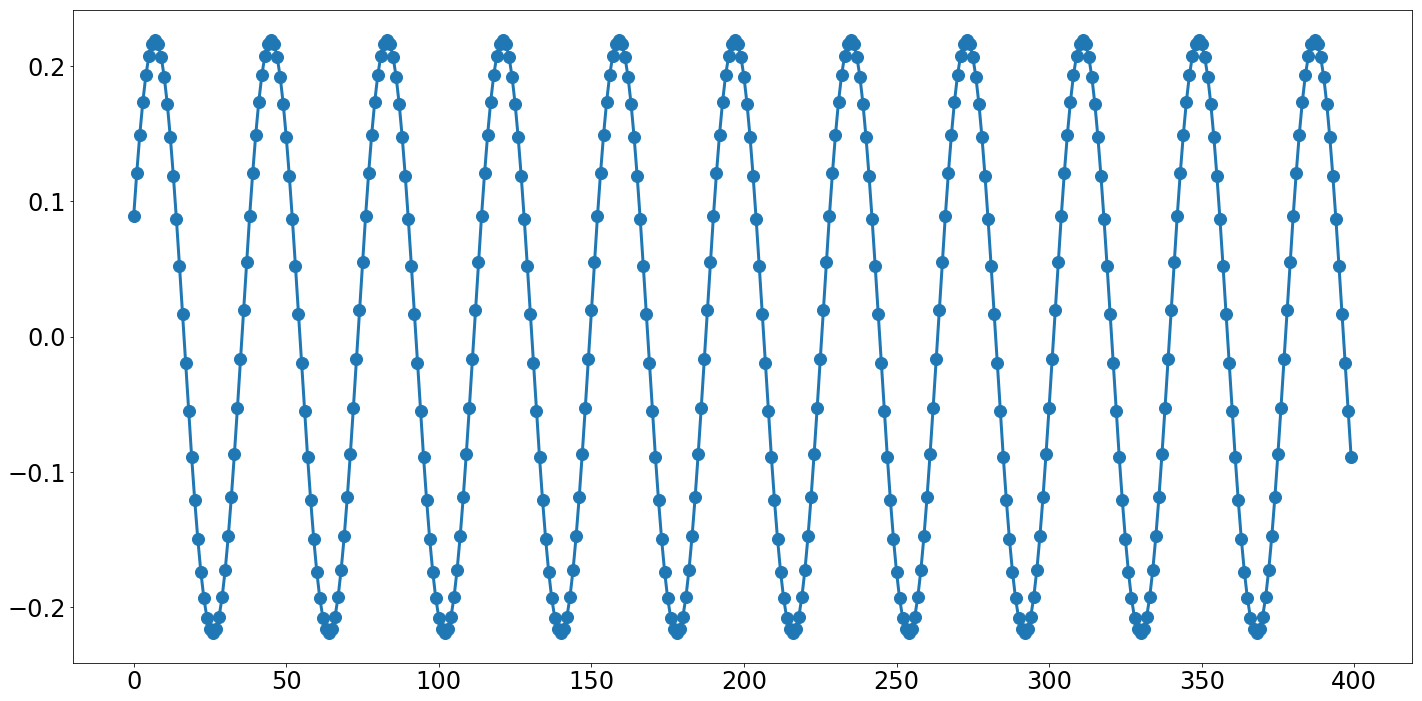

In [9]:
plt.plot(X_test[0], '-o')

# Define Attention

In [10]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()

    def get_scores(self, e, h):
        """
        e has a shape [batch_size, time_len_in_e, dim_e]
        h has a shape [batch_size, time_len_in_h, dim_h]
        Returns matrix of scores with shape [batch_size, time_len_in_h, time_len_in_e].
        """
        raise NotImplementedError()                

    def forward(self, e, h):
        """
        e has a shape [batch_size, time_len_in_e, dim_e]
        h has a shape [batch_size, time_len_in_h, dim_h]     
        
        result has a shape [batch_size, time_len_in_h, dim_e]
        alpha has a shape [batch_size, time_len_in_h, time_len_in_e]
        
        """
        scores = self.get_scores(e, h)
        alphas = F.softmax(scores, 2)
        result = torch.bmm(alphas, e)
        return result, alphas
      
    
class AdditiveAttention(Attention):
    def __init__(self, dim_e, dim_h, hidden_dim, device = 'cpu'):
        """
        dim_e      - hidden dimension of encoder
        dim_h      - hidden dimension of decoder
        hidden_dim - hidden dimension of attention
        """
        super(AdditiveAttention, self).__init__()
        
        self.dim_e = dim_e
        self.dim_h = dim_h
        self.hidden_dim = hidden_dim
        
        self.W1 = nn.Linear(dim_e, hidden_dim, bias=False)
        self.W2 = nn.Linear(dim_h, hidden_dim, bias=False)
        self.w3 = nn.Linear(hidden_dim, 1, bias=False)
        self.to(device)

    def get_scores(self, e, h):
        """
        e has a shape [batch_size, time_len_in_e, dim_e]
        h has a shape [batch_size, time_len_in_h, dim_h]
        Returns matrix of scores with shape [batch_size, time_len_in_h, time_len_in_e].
        
        """
        f = self.W1(e).view(e.shape[0], 1, e.shape[1], -1)
        q = self.W2(h).view(h.shape[0], h.shape[1], 1, -1)
        a = torch.tanh(f + q)
        result = self.w3(a)[:, :, :, 0]
        return result

class MultiplicativeAttention(Attention):
    def __init__(self, dim_e, dim_h, hidden_dim, device = 'cpu'):
        super(MultiplicativeAttention, self).__init__()

    def get_scores(self, e, h):
        """
        e has a shape [batch_size, time_len_in_e, dim_e]
        h has a shape [batch_size, time_len_in_h, dim_h]
        Returns matrix of scores with shape [batch_size, time_len_in_h, time_len_in_e].
        """
        return torch.bmm(h, e.transpose(1, 2))

# Define seq2seq

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, bidirectional = False, device = 'cpu'):
        super(Encoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.device = device
        
        self.num_direction = int(bidirectional + 1)
        
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional = bidirectional)
        self.linear = nn.Linear(self.num_direction*hidden_dim, input_dim)
        
        self.to(device)
        
    def forward(self, input):
        """
        input data:
            input has a shape [batch_size, time_len, input_dim]
        
        return data:
            output has a shape [batch_size, time_len, input_dim]
            encoder_out has a shape [batch_size, time_len, hidden_dim*num_direction]
            h, c --- hidden vector of LSTM for all layer
            d --- hidden vector of LSTM for last layer
        """
        input = torch.transpose(input, 0, 1)
        encoder_out, (encoder_h, encoder_c) = self.encoder(input)
        
        h = encoder_h
        c = encoder_c
        d = encoder_out[-1].unsqueeze(0)
        encoder_out = torch.transpose(encoder_out, 0, 1)
        output = self.linear(encoder_out)
        
        return output, encoder_out, h, c, d

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, a_hidden_dim = None, bidirectional = False, device = 'cpu'):
        super(Decoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.device = device
        
        self.num_direction = int(bidirectional + 1)
        
        self.decoder = nn.LSTM(input_dim + self.num_direction*hidden_dim, hidden_dim, num_layers, bidirectional = bidirectional)
        self.linear = nn.Linear(self.num_direction*hidden_dim, input_dim)
        
        if a_hidden_dim is not None:
            self.attention = AdditiveAttention(self.num_direction*hidden_dim, self.num_direction*hidden_dim, a_hidden_dim, device = device)
        else:
            self.attention = MultiplicativeAttention(self.num_direction*hidden_dim, self.num_direction*hidden_dim, a_hidden_dim, device = device)
      
        
        self.to(device)
        
    def forward(self, input, e, h, c, d, max_len = 50, time_len_encoder = 100):
        """
        input data:
            input has a shape [batch_size, 1, input_dim], it is should be a zeros vectore
        
        return data:
            output has a shape [batch_size, max_len, output_dim]
            alphas has a shape [max_len, batch_size, time_len_encoder]
            decoder_out has s shape [batch_size, max_len, hidden_dim*num_direction]
        """
        input = torch.transpose(input, 0, 1)
        answers = torch.zeros(max_len, input.shape[1], self.input_dim).to(self.device)
        decoder_out = torch.zeros(max_len, input.shape[1], self.hidden_dim*self.num_direction).to(self.device)
        alphas = torch.zeros(input.shape[1], max_len, time_len_encoder).to(self.device)
        
        for i in range(max_len):
            d = torch.transpose(d, 0, 1)
            contex, alpha = self.attention(e, d)
            contex = torch.transpose(contex, 0, 1)
            
            input = torch.cat((input, contex), dim = 2)
            d, (h, c) = self.decoder(input, (h, c))
            input = self.linear(d)
            
            alphas[:, i, :] = alpha[:, 0, :]
            decoder_out[i] = d[0]
            answers[i] = input[0]
        
        output = torch.transpose(answers, 0, 1)
        decoder_out = torch.transpose(decoder_out, 0, 1)
        
        return output, alphas, decoder_out
    
    
class seq2seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, a_hidden_dim = None, num_layers=1, bidirectional = False, device = 'cpu'):
        super(seq2seq, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = device
        
        self.num_direction = int(bidirectional + 1)
        
        self.encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, bidirectional=bidirectional, device = device)
        self.decoder = Decoder(input_dim=output_dim, hidden_dim=hidden_dim, num_layers=num_layers, a_hidden_dim = a_hidden_dim, bidirectional = bidirectional, device = device)
    
        self.to(device)
    
    def forward(self, input, max_len = 50):
        
        answers_enc, encoder_out, h, c, d = self.encoder(input)
        
        answer = torch.zeros(input.shape[0], 1, self.output_dim).to(self.device)
        answers_dec, alphas, decoder_out = self.decoder(answer, encoder_out, h, c, d, max_len, input.shape[1])
        
        return answers_enc, answers_dec, alphas, encoder_out, decoder_out
    

# Model trainer

In [12]:
class callback():
    def __init__(self, writer, X, Y, delimeter = 100, device = 'cpu'):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        
        self.X = torch.FloatTensor(X).to(device)
        self.Y = torch.FloatTensor(Y).to(device)
        
        
      
    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LSTM/scalar', loss.cpu().data.numpy(), self.step)
        
        if self.step % self.delimeter == 0:
            ind = 2*self.X.shape[1]//3
            
            input_batch = self.X[:, :ind, :]
            output_batch = self.Y[:, ind:, :]

            answers_enc, answers_dec, alphas, encoder_out, decoder_out = model(input_batch, max_len = output_batch.shape[1])
            
            fig = plt.figure()
            plt.plot(np.reshape(output_batch.cpu().data.numpy(), [-1]), '-o')
            plt.plot(np.reshape(answers_dec.cpu().data.numpy(), [-1]), '-o')
            self.writer.add_figure('LSTM/TimeSeries', fig, self.step)

            fig = plt.figure()
            plt.imshow(alphas[0, :, :].cpu().data.numpy())
            plt.colorbar()
            self.writer.add_figure('LSTM/Attention', fig, self.step)
            
            
    def __call__(self, model, loss):
        return self.forward(model, loss)

In [13]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    """
    x_batch has a shape [batch_size, time_len_in, input_dim]
    y_batch has a shape [batch_size, time_len_out, time_len_in]
    """
    model.zero_grad()

    r = np.random.randint(x_batch.shape[1]//5, 2*x_batch.shape[1]//5)
    ind = np.random.randint(2*x_batch.shape[1]//5 + 1, x_batch.shape[1])
    input_batch = x_batch[:, :r, :]
    output_batch = y_batch[:, r:ind, :]
    
    answers_enc, answers_dec, alphas, encoder_out, decoder_out = model.forward(input_batch, max_len = output_batch.shape[1])
    
    loss = loss_function(answers_dec, output_batch)
    
    loss.backward()

    optimizer.step()

    return loss.detach()

def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    model.train()
    loss = torch.zeros(1).to(str(model.device))
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        loss = train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)
        if callback is not None:
            callback(model, loss)
    return

def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None
           ):

    optima = optimizer(model.parameters(), lr = lr)
    
    for it in tqdm(range(count_of_epoch)):

        batch_generator = DataLoader(dataset = dataset, batch_size=batch_size, shuffle=True)
        
        train_epoch(train_generator = batch_generator, model = model, loss_function = loss_function, optimizer = optima, callback=callback)

    return

# Define Model

In [14]:
loss_fuction = torch.nn.MSELoss()
optimizer = torch.optim.Adam

dataset = TimeSeries(X_train, X_train, device = device)

In [15]:
model = seq2seq(input_dim = 1,
                hidden_dim = 2,
                output_dim = 1,
                a_hidden_dim = 10,
                device = device)

In [16]:
# writer = SummaryWriter(log_dir = '/tmp/log')

# writer = SummaryWriter()

# call = callback(writer, X_test[:1], X_test[:1], delimeter = 50, device = device)


In [17]:
# import requests
# r = requests.get('https://raw.githubusercontent.com/andriygav/Attention/master/code/runs/SinusDim50ClasAtt/model.pt', allow_redirects=True)
# open('/tmp/log/model.pt', 'wb').write(r.content)
# model.load_state_dict(torch.load('/tmp/log/model.pt', map_location=device))


In [18]:
# %tensorboard --logdir /tmp/log

In [19]:
# trainer(count_of_epoch = 1,
#         batch_size = 64,
#         dataset = dataset,
#         model = model,
#         loss_function = loss_fuction,
#         optimizer = optimizer,
#         lr = 0.001,
# #         callback = call
#        )

In [20]:
# torch.save(model.state_dict(), '/tmp/log/model.pt')

In [21]:
# files.download('/tmp/log/model.pt')

In [22]:
model.load_state_dict(torch.load('./runs/TwoImpulseExperimentDim2/model.pt', map_location=device))
model.eval()

seq2seq(
  (encoder): Encoder(
    (encoder): LSTM(1, 2)
    (linear): Linear(in_features=2, out_features=1, bias=True)
  )
  (decoder): Decoder(
    (decoder): LSTM(3, 2)
    (linear): Linear(in_features=2, out_features=1, bias=True)
    (attention): AdditiveAttention(
      (W1): Linear(in_features=2, out_features=10, bias=False)
      (W2): Linear(in_features=2, out_features=10, bias=False)
      (w3): Linear(in_features=10, out_features=1, bias=False)
    )
  )
)

In [23]:
X = torch.Tensor(X_test[:1]).to(device)
Y = torch.Tensor(X_test[:1]).to(device)

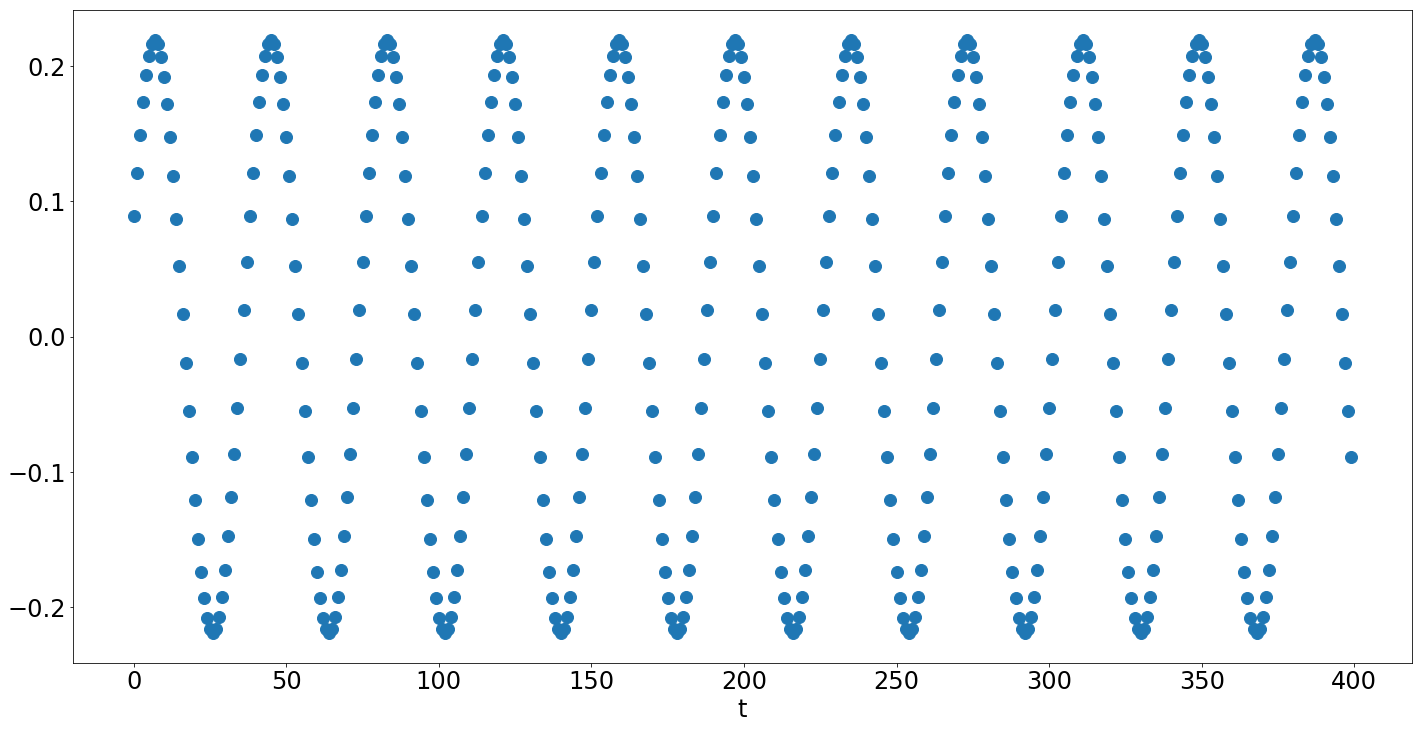

In [24]:
plt.plot(np.reshape(X.cpu().data.numpy(), [-1]), 'o')

plt.xlabel('t')
plt.show()

In [25]:
answers_enc, answers, alphas, encoder_out, decoder_out = model(X, max_len = X.shape[1])

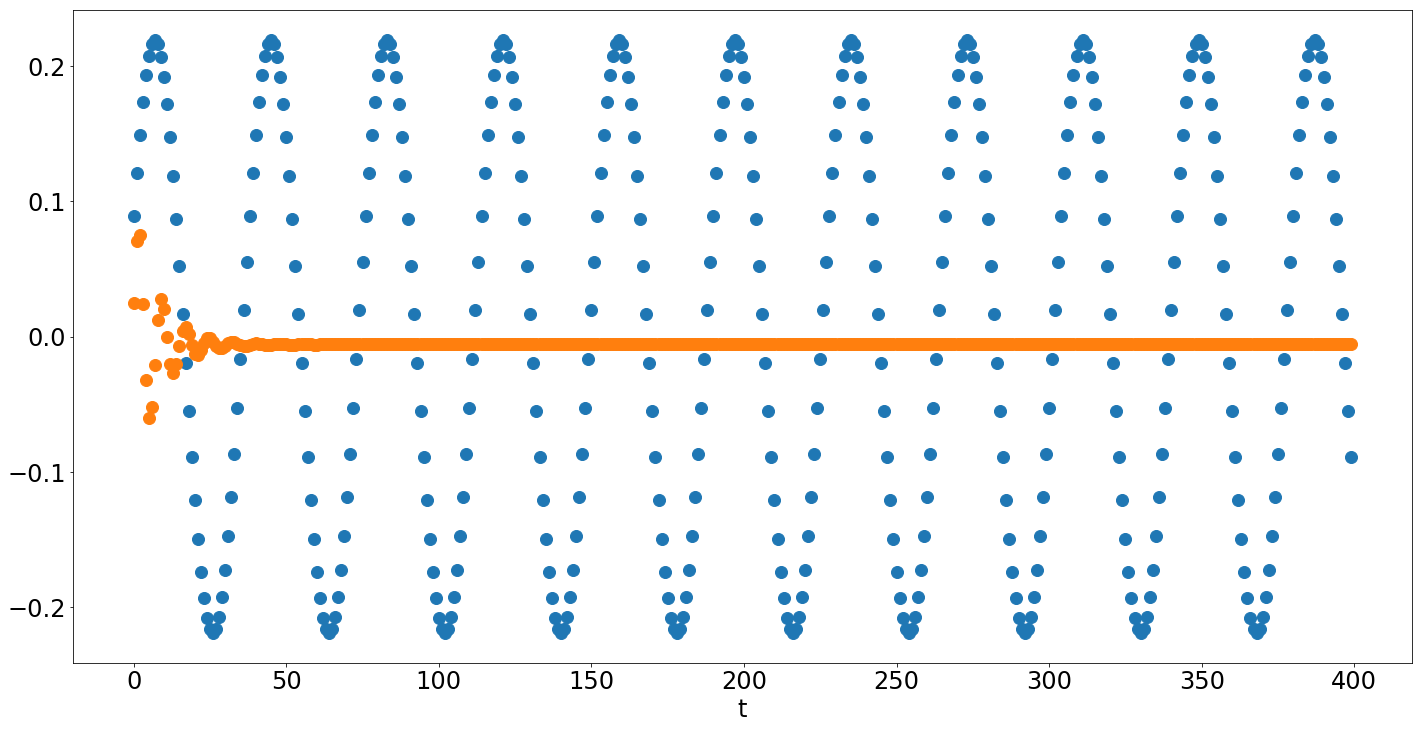

In [26]:
plt.plot(np.reshape(Y.cpu().data.numpy(), [-1]), 'o')
plt.plot(np.reshape(answers.cpu().data.numpy(), [-1]), 'o')

plt.xlabel('t')
plt.show()

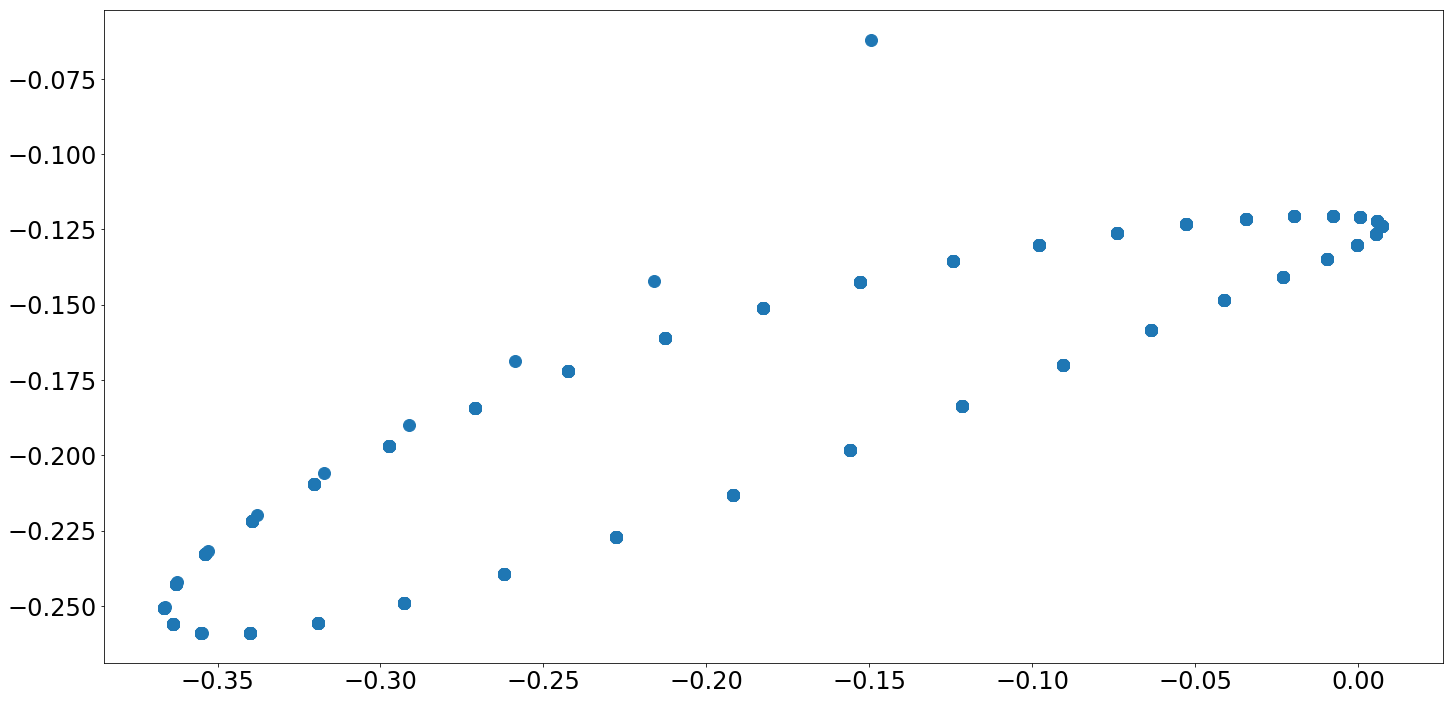

In [27]:
h = encoder_out.cpu().data.numpy()[0]
plt.plot(h[:, 0], h[:, 1], 'o')

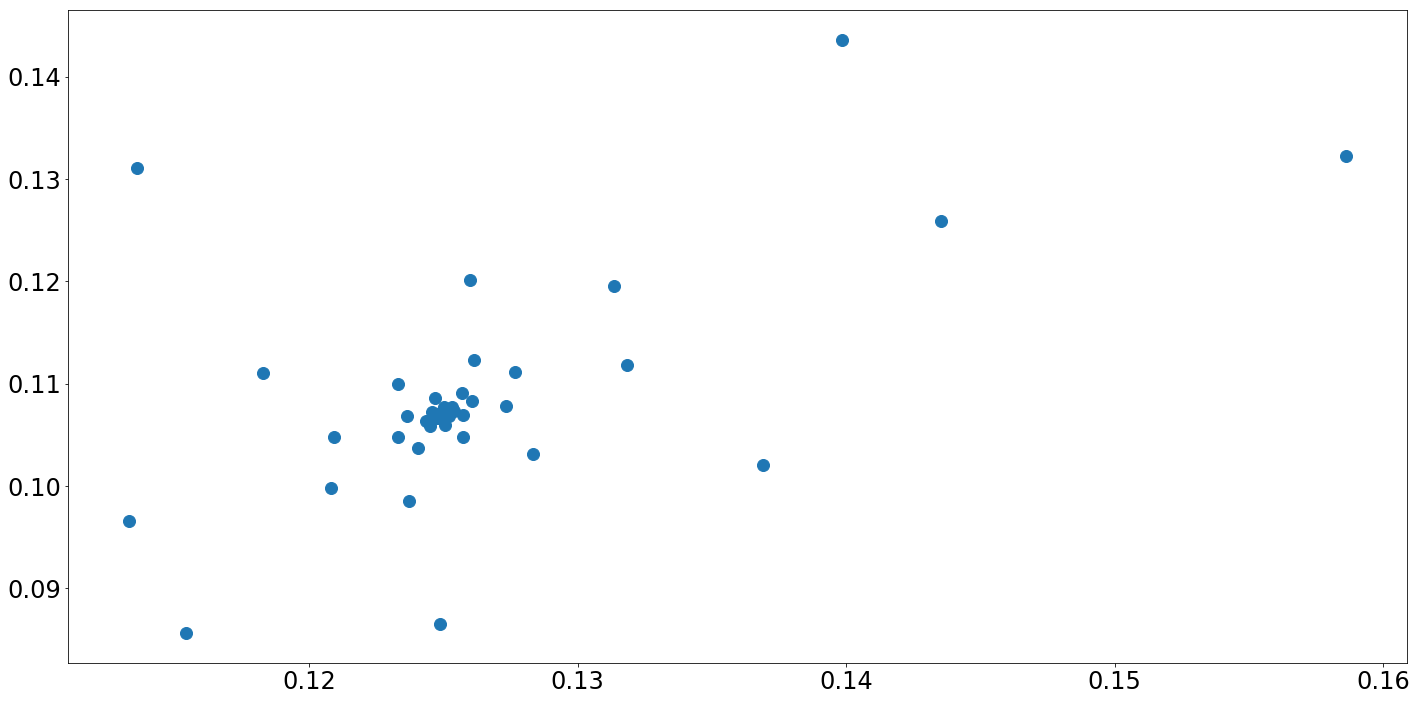

In [28]:
h = decoder_out.cpu().data.numpy()[0]
plt.plot(h[:, 0], h[:, 1], 'o')

In [29]:
# h = decoder_out.cpu().data.numpy()[0]
# plt.plot(h[:, 0], h[:, 1], 'o')

In [30]:
# plt.imshow(alphas[0, :, :].cpu().data.numpy())
# plt.colorbar()

# plt.show()